# Predicción de valores en series de criptomonedas

### 1) Instalamos e importamos librerias

In [1]:
!pip install pickle5

     |████████████████████████████████| 256 kB 4.2 MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import datetime
import timeit
from tqdm import tqdm
import glob
import seaborn as sns
import pickle5 as pickle

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader

# Dfinimos función para uso de CUDA
def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
          "if possible, in the menu under `Runtime` -> "
          "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [4]:
# Set the device (check if gpu is available)
device = set_device()

GPU is enabled in this notebook.


### 2) Carga y agregación de los Dataset

In [5]:
# Drive con espacio
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'Cripto_prediction/data/'

Mounted at /content/gdrive


In [6]:
# Drive sin espacio
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/MyDrive/" #changed this for my drive (AP)
base_dir = root_dir + 'Cripto_prediction/data/'
model_dir = root_dir + 'Cripto_prediction/models/'

Mounted at /content/gdrive


Levantamos todos los datasets como Dataframes de Pandas. Ordenamos por la columna time ya que algunos estaban desordenados.

In [7]:
with open(base_dir+'adausdt.pkl', 'rb') as f:
    data_ada = pickle.load(f)
    data_ada = data_ada.sort_values(by="time")

with open(base_dir+'avaxusdt.pkl', 'rb') as f:
    data_avax = pickle.load(f)
    data_avax = data_avax.sort_values(by="time")

with open(base_dir+'btcusdt.pkl', 'rb') as f:
    data_btc = pickle.load(f)
    data_btc = data_btc.sort_values(by="time")

with open(base_dir+'cakeusdt.pkl', 'rb') as f:
    data_cake = pickle.load(f)
    data_cake = data_cake.sort_values(by="time")

with open(base_dir+'dotusdt.pkl', 'rb') as f:
    data_dot = pickle.load(f)
    data_dot = data_dot.sort_values(by="time")

with open(base_dir+'ethusdt.pkl', 'rb') as f:
    data_eth = pickle.load(f)
    data_eth = data_eth.sort_values(by="time")

with open(base_dir+'linkusdt.pkl', 'rb') as f:
    data_link = pickle.load(f)
    data_link = data_link.sort_values(by="time")

with open(base_dir+'maticusdt.pkl', 'rb') as f:
    data_matic = pickle.load(f)
    data_matic = data_matic.sort_values(by="time")

with open(base_dir+'solusdt.pkl', 'rb') as f:
    data_sol = pickle.load(f)
    data_sol = data_sol.sort_values(by="time")

with open(base_dir+'thetausdt.pkl', 'rb') as f:
    data_theta = pickle.load(f)
    data_theta = data_theta.sort_values(by="time")

with open(base_dir+'vetusdt.pkl', 'rb') as f:
    data_vet = pickle.load(f)
    data_vet = data_vet.sort_values(by="time")

# ahora data es un data frame de pandas con toda la información.

Veamos que hay saltos temporales donde no tenemos datos, faltan valores, no todos estan equiespaciados. Esot pasa en todas las cripto, mostramos una como ejemplo:

In [8]:
dummy_df = pd.DataFrame()
dummy_df['salto'] = data_avax.time.diff()
dummy_df.salto.value_counts()

0 days 00:01:00           569503
0 days 01:01:00                2
0 days 04:31:00.999000         1
0 days 03:53:00                1
0 days 01:31:00                1
0 days 00:00:35.007000         1
0 days 00:00:57.600000         1
0 days 04:45:02.400000         1
0 days 00:00:59.001000         1
0 days 02:01:00                1
0 days 02:31:00                1
0 days 00:00:54.247000         1
0 days 01:20:05.753000         1
0 days 00:00:24.993000         1
Name: salto, dtype: int64

Vamos a unir todos los Dataframes por la columna `'time'`. Solo conservamos los tiempos para los cuales tenemos el valor de todas las criptomonedas, los demas se descartan.

In [9]:
##########  Each cripo has different lenght ###############

data = pd.merge(data_ada, data_avax, on='time',suffixes=('_ada', '_avax'))
data = pd.merge(data, data_btc, on='time',suffixes=('', '_btc'))
data = pd.merge(data, data_cake, on='time',suffixes=('', '_cake'))
data = pd.merge(data, data_dot, on='time',suffixes=('', '_dot'))
data = pd.merge(data, data_eth, on='time',suffixes=('', '_eth'))
data = pd.merge(data, data_link, on='time',suffixes=('', '_link'))
data = pd.merge(data, data_matic, on='time',suffixes=('', '_matic'))
data = pd.merge(data, data_sol, on='time',suffixes=('', '_sol'))
data = pd.merge(data, data_theta, on='time',suffixes=('', '_theta'))
data = pd.merge(data, data_vet, on='time',suffixes=('', '_vet'))

data = data.rename(columns = {'close': 'close_btc'})
data = data.sort_values(by="time")
data["time"] = data["time"].dt.round('1min')  

data.shape

(353706, 12)

In [10]:
list_coins = ['close_ada', 'close_avax', 'close_btc', 'close_cake', 'close_dot','close_eth', 'close_link', 'close_matic', 'close_sol', 'close_theta','close_vet']
coin_dic = dict(zip(list_coins, range(len(list_coins))))

Vamos a heredar la falta de valores de todas las cripto (ya que si falta el valor temporal para una pedemos esa instancia). Notemos cuales osn los valores faltantes:

In [11]:
dummy_df = pd.DataFrame()
dummy_df['salto'] = data.time.diff()
valores_faltantes = dummy_df.salto.value_counts()
dummy_df.salto.value_counts()

0 days 00:01:00    353700
0 days 04:31:00         1
0 days 02:31:00         1
0 days 04:46:00         1
0 days 01:31:00         1
0 days 02:01:00         1
Name: salto, dtype: int64

In [12]:
faulty_indices = []
for i in range(1, len(valores_faltantes)):
    indice_salto = dummy_df[dummy_df.salto==valores_faltantes.index[i]].index.values[0]
    faulty_indices.append(indice_salto-1)
faulty_indices = np.sort(faulty_indices)

Entre el `i-1` y el indice `i` el salto es mayor a 1 minuto.

In [13]:
faulty_indices

array([ 21359,  86069,  93239, 251234, 318944])

In [14]:
data.tail()

,time,close_ada,close_avax,close_btc,close_cake,close_dot,close_eth,close_link,close_matic,close_sol,close_theta,close_vet
353701,2021-10-23 12:17:00,2.161,66.76,61458.50,19.82,44.18,4034.16,30.72,1.587,201.45,6.518,0.13694
353702,2021-10-23 12:18:00,2.162,66.85,61520.13,19.83,44.23,4038.97,30.77,1.594,201.83,6.524,0.13703
353703,2021-10-23 12:19:00,2.161,66.87,61457.61,19.82,44.22,4036.80,30.75,1.593,201.49,6.520,0.13709
353704,2021-10-23 12:20:00,2.161,66.80,61482.29,19.81,44.21,4038.50,30.73,1.591,201.63,6.523,0.13706
353705,2021-10-23 12:21:00,2.161,66.72,61478.84,19.82,44.20,4040.14,30.76,1.588,202.03,6.523,0.13687


### 3) Preprocesamiento y selección de features

Definimos los hiperparámetros del Dataset.

In [15]:
# Data Parameters
BATCH_SIZE = 64
SEQ_LEN = 600
TEST_RATIO = 0.8
COIN =  'close_btc' #'close_sol'
PORCENTAJE = 0.3
PASOS_FUTURO = 60
NOISE_LEVEL = 10

REGRESSION = 1

# SEQ_LEN has to be divisible by REDUCTION_STEP
REDUCTION_STEP = 10

# Network Parameters
base_filters = 128
kernel_size = 8
n_block = 8
n_classes = 1
stride = 2
groups = 8
lr = 0.0002 # 0.001

# Filename
file_name = model_dir + '1DConv_' + COIN
model_name = file_name + '.pt'

In [16]:
# Guardamos un archivo txt con todos los parámetros elegidos en la corrida
# (Esto será un archivo legible por humano)
with open(file_name+'_parameters'+'.txt', "w") as text_file:
    print(f"BATCH_SIZE: {BATCH_SIZE}", file=text_file)
    print(f"SEQ_LEN: {SEQ_LEN}", file=text_file)
    print(f"TEST_RATIO: {TEST_RATIO}", file=text_file)
    print(f"COIN: {COIN}", file=text_file)
    print(f"PORCENTAJE: {PORCENTAJE}", file=text_file)
    print(f"PASOS_FUTURO: {PASOS_FUTURO}", file=text_file)
    print(f"NOISE_LEVEL: {NOISE_LEVEL}", file=text_file)
    print(f"REGRESSION: {REGRESSION}", file=text_file)
    print(f"REDUCTION_STEP: {REDUCTION_STEP}", file=text_file)
    print(f"base_filters: {base_filters}", file=text_file)
    print(f"kernel_size: {kernel_size}", file=text_file)
    print(f"n_block: {n_block}", file=text_file)
    print(f"n_classes: {n_classes}", file=text_file)
    print(f"stride: {stride}", file=text_file)
    print(f"groups: {groups}", file=text_file)
    print(f"lr: {lr}", file=text_file)

# Guardamos también diccionario para que luego sea mas facil levantar los parámetros
dictio_param = {'BATCH_SIZE': BATCH_SIZE, 'SEQ_LEN' : SEQ_LEN,
                'TEST_RATIO': TEST_RATIO,'COIN': COIN, 
                'PORCENTAJE': PORCENTAJE, 'PASOS_FUTURO': PASOS_FUTURO,
                'NOISE_LEVEL': NOISE_LEVEL, 'REGRESSION': REGRESSION, 'REDUCTION_STEP': REDUCTION_STEP,
                'base_filters': base_filters, 'kernel_size': kernel_size,
                'n_block': n_block, 'n_classes': n_classes,
                'stride': stride, 'groups': groups, 'lr': lr}

with open(file_name+'_dictionary'+'.pickle', 'wb') as handle:
    pickle.dump(dictio_param, handle, protocol=pickle.HIGHEST_PROTOCOL)

Tomamos la resolución temporal deseada en la que vamos a trabajar, en este caso con data cada 1 minuto.

In [17]:
# # Si queremos Hacer Downsampling
# serie_raw = np.asarray(data[list_coins])
# downsample_ratio = 1
# series_dimension = 11 # sries.shape[1]
# serie_original = serie_raw[:(len(serie_raw)//downsample_ratio)*downsample_ratio].reshape(-1, downsample_ratio, series_dimension).mean(axis = 1)

# Usando la data Minuto a Minuto:
serie_original = np.asarray(data[list_coins])

Transformamos la serie de valores a un cambio porcentual, el `Log Return`. Luego también consideramos el cambio en el valor absoluto de la serie.

In [18]:
# Porcentaje de datos a tomar
ultimos_datos = int(serie_original.shape[0] * PORCENTAJE)

# Arreglamos indices faltante segun PORCENTAJE
desechados = serie_original.shape[0]-ultimos_datos
nuevos_indices = []
for indice in faulty_indices:
    if (indice - desechados)>=0:
        nuevos_indices.append(indice - desechados)
faulty_indices = np.asarray(nuevos_indices)

# Tomamos ultimos datos
serie_original = serie_original[-ultimos_datos:]

# Definimos serie de Log Returns
serie_log_return = np.log(np.divide(np.roll(serie_original, -1, axis=0),serie_original))
serie_log_return = 100*serie_log_return[:-PASOS_FUTURO]

# Definimos la series de cambio Absoluto
serie_crecimiento_absoluto = np.roll(serie_original, -1, axis=0) - serie_original
serie_crecimiento_absoluto = serie_crecimiento_absoluto[:-PASOS_FUTURO]

# Definimos el Log return a 15 minutos en adelante
serie_target = np.log(np.divide(np.roll(serie_original, -PASOS_FUTURO, axis=0),serie_original))
serie_target = 100*serie_target[:-PASOS_FUTURO]

if REGRESSION == 0:
    serie_target = (serie_target > 0).astype(int)

X = serie_log_return
print(X.shape)

(106051, 11)


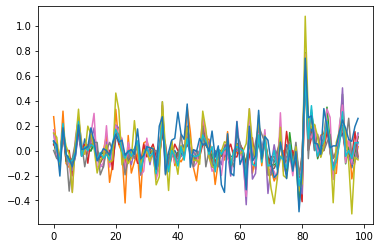

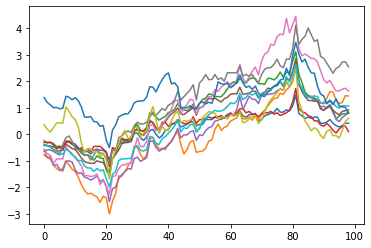

In [19]:
plt.plot(serie_log_return[-100:-1])
plt.show()

plt.plot(serie_target[-100:-1])
plt.show()

In [22]:
data_filename = 'data_X_btc_ADP'
np.save(data_filename, X)
data_filename = 'data_Y_btc_ADP'
np.save(data_filename, serie_target)
data_filename = 'faulty_indices_btc_ADP'
np.save(data_filename, faulty_indices)

In [23]:
file_to_store = open("pickle_btc_ADP", "wb")
pickle.dump([X,serie_target,serie_target,faulty_indices], file_to_store)
file_to_store.close()

### 4) Definición de Datasets y Dataloaders

In [ ]:
from torch import Tensor
from torch.distributions.normal import Normal

class DataTransformer:
    def __init__(self,std_series):

        # self.gaussian = Normal(0.0, 0.5)

        self.transforms = [
            # self.dropout,
            self.add_gaussian_noise,
            # self.dropout_and_noise,
            self.chunk_dropout,
            self.chunk_copy,
            self.chunk_swap,
            # self.alternate_dropout,
            self.channel_dropout,
            self.identity,
        ]

        self.dropout_p = 0.2
        self.chunk_length = 0.2

    def transform(self, x):
        def _fn(x):
            return np.random.choice(self.transforms)(x)

        return _fn(x)

    def add_gaussian_noise(self, x):
        # x = x + self.gaussian.sample(x.shape)
        # return x
        for i in range(x.shape[1]):
            noise = np.random.normal(0,NOISE_LEVEL*std_series[i]/100,x.shape[0])
            x[:,i] = x[:,i] + noise
        return x

    def dropout_and_noise(self, x):
        x = self.add_gaussian_noise(x)
        return self.transforms[0](x)

    def chunk_dropout(self, x):
        chunk_size = int(len(x) * self.chunk_length)
        chunk_start = np.random.randint(0, len(x) - chunk_size)
        x[chunk_start: chunk_start + chunk_size] = 0
        return x

    def chunk_copy(self, x):
        chunk_length = int(len(x) * self.chunk_length)
        chunk_start = np.random.randint(chunk_length * 2,
                                        len(x) - chunk_length * 2)
        chunk_end = chunk_start + chunk_length
        chunk = x[chunk_start: chunk_end].copy()

        direction = np.random.choice(['left', 'right'])
        if direction == 'left':
            start = chunk_start - chunk_length
            end = chunk_start
        else:
            start = chunk_end
            end = chunk_end + chunk_length
        x[start: end] = chunk
        return x

    def chunk_swap(self, x):
        # get a random chunk of the sequence
        chunk_length = int(len(x) * self.chunk_length)
        chunk_start = np.random.randint(chunk_length * 2,
                                        len(x) - chunk_length * 2)

        chunk_end = chunk_start + chunk_length
        chunk = x[chunk_start: chunk_end]

        direction = np.random.choice(['left', 'right'])
        if direction == 'left':
            start = chunk_start - chunk_length
            end = chunk_start
        else:
            start = chunk_end
            end = chunk_end + chunk_length

        # swap
        tmp = x[start: end].copy()
        x[start: end] = chunk
        x[chunk_start: chunk_end] = tmp
        return x

    def dropout(self, x):
        points_to_dropout = np.argwhere(
            np.random.choice([True, False], size=len(x),
                             p=[self.dropout_p, 1 - self.dropout_p]))
        x[points_to_dropout.reshape(-1)] = 0
        return x

    def alternate_dropout(self, x):
        x[::2] = 0
        return x

    def channel_dropout(self, x):
        num_channels = x.shape[1]
        channel = np.random.choice(list(range(num_channels)))
        x[:, channel] = 0
        return x

    def identity(self, x):
        return x


In [ ]:
def series_train_test_split(X,Y,faulty_indices,test_ratio = 0.8):
    total_len = len(X)
    train_length = int(test_ratio * total_len)
    X_train = X[:train_length]
    X_test = X[train_length:]
    Y_train = Y[:train_length]
    Y_test = Y[train_length:]
    faulty_indices_train = []
    faulty_indices_test = []
    for indice in faulty_indices:
        if indice < train_length:
            faulty_indices_train.append(indice)
        else: 
            faulty_indices_test.append(indice-train_length)
    return X_train, Y_train, X_test, Y_test, faulty_indices_train, faulty_indices_test

In [ ]:
Y = serie_target[:,coin_dic[COIN]:coin_dic[COIN]+1]

X_train, Y_train, X_test, Y_test, faulty_indices_train, faulty_indices_test = series_train_test_split(X,Y,faulty_indices,test_ratio = TEST_RATIO)

std_series = np.std(X_train,axis=0)
std_series_test = np.zeros_like(std_series)

NameError: ignored

In [ ]:
print(X_train.shape)
print(Y_train.shape)
print(faulty_indices_train)

print(X_test.shape)
print(Y_test.shape)
print(faulty_indices_test)

(84840, 11)
(84840, 1)
[]
(21211, 11)
(21211, 1)
[]


In [ ]:
class TimeseriesDataset(torch.utils.data.Dataset):   
    def __init__(self, X, y, faulty_indices, std_series , seq_len=10, is_train = 1):
        self.X = X
        self.y = y
        self.seq_len = seq_len
        self.faulty_indices = faulty_indices
        self.diccionario_indices = self.generate_dict()
        self.transformer = DataTransformer(std_series)
        self.is_train = is_train

    def generate_dict(self):
        # Numero total de instancias en el Dataset
        numero_total = len(self.X)

        # Cantidad de pasos necesarios para definir una instancia
        ventanita = np.ones(self.seq_len + PASOS_FUTURO)

        # Definimos las regiones donde no hay valores faltantes en la ventana
        fallas = np.zeros(numero_total)
        for i in self.faulty_indices:
            fallas[i] = 1
        region_fallas = np.convolve(fallas, ventanita, mode='valid')
        len_convolve = len(region_fallas) # numero_total - len(ventanita) + 1

        # Contamos las instancias validas
        dataset_len = len_convolve - (region_fallas>0).sum()

        # Definimos un diccionario para los indices validos
        indices_fallas = np.arange(len_convolve)
        diccionario_indices = indices_fallas[region_fallas==0]

        return diccionario_indices

    def __len__(self):
        dataset_len = len(self.diccionario_indices)
        return dataset_len

    def __getitem__(self, index):
        dict_index = self.diccionario_indices[index]
        instance = self.X[dict_index:dict_index+self.seq_len]
        # for i in range(X.shape[1]):
        #     noise = np.random.normal(0,NOISE_LEVEL*std_series[i]/100,self.seq_len)
        #     instance[:,i] = instance[:,i] + noise
        target = self.y[dict_index+self.seq_len]

        instance = instance[len(instance)%REDUCTION_STEP:]
        instance = np.add.reduceat(instance, np.arange(0, len(instance), REDUCTION_STEP),axis = 0)
        if self.is_train == 1:
            instance = self.transformer.transform(instance)
            scaling_factor = np.random.uniform(0.5, 1.5)
            instance = instance * scaling_factor
            if REGRESSION == 1:
                target = target * scaling_factor
                
        instance = np.transpose(instance, (1, 0))       
        return (instance,target)

In [ ]:
train_dataset = TimeseriesDataset(X_train, Y_train, faulty_indices_train, std_series ,  seq_len=SEQ_LEN , is_train = 1)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last=True)

valid_dataset = TimeseriesDataset(X_test, Y_test, faulty_indices_test, std_series_test , seq_len=SEQ_LEN, is_train = 0)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last=True)

In [ ]:
print( train_dataset.X.shape )
print( train_dataset.__len__() )
print( train_dataset.__getitem__(5) )

print( train_dataset.__getitem__(5)[0].shape )
print( train_dataset.__getitem__(5)[1].shape )


(84840, 11)
84181
(array([[ 7.31199878e-01, -1.94476493e+00,  7.25637157e-01,
         1.37745812e-02,  8.26107147e-02, -2.34227557e-01,
        -3.79973383e-01, -8.30807539e-02, -6.23524194e-02,
         6.92981971e-03,  5.54225997e-02, -3.39909456e-01,
        -6.41093802e-01,  8.14650295e-01, -2.77824056e-01,
         6.03359180e-01, -3.11662613e-01, -3.61264088e-01,
        -1.29512615e+00,  2.11260704e-02, -2.89080289e-01,
         3.73543382e-01,  9.24772082e-01, -3.91363514e-01,
         1.40016494e-02,  3.14559465e-01,  5.15297143e-01,
         7.95965115e-01, -5.51825528e-02,  2.68749751e-01,
         1.30688154e-01,  4.39055997e-01,  1.80348665e-14,
         2.18862285e-01, -2.39403319e-01, -1.43896437e-01,
         1.43896437e-01,  3.42328934e-02,  1.50496308e-01,
         3.34446559e-01,  2.72562154e-02,  1.36255357e-02,
         9.53307786e-02,  1.49636166e-01,  4.20592922e-01,
         2.37065478e+00,  1.64346600e+00,  2.52139414e+00,
        -1.27593055e+00,  3.28432662e

### 5) Definición del Modelo

Definimos una red neuronal MLP regularizada con Dropout L1 y L2.

In [ ]:
"""
resnet for 1-d signal data, pytorch version
 
Shenda Hong, Oct 2019
"""

import numpy as np
from collections import Counter
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report 

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


class MyConv1dPadSame(nn.Module):
    """
    extend nn.Conv1d to support SAME padding
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups=1):
        super(MyConv1dPadSame, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.conv = torch.nn.Conv1d(
            in_channels=self.in_channels, 
            out_channels=self.out_channels, 
            kernel_size=self.kernel_size, 
            stride=self.stride, 
            groups=self.groups)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.conv(net)

        return net
        
class MyMaxPool1dPadSame(nn.Module):
    """
    extend nn.MaxPool1d to support SAME padding
    """
    def __init__(self, kernel_size):
        super(MyMaxPool1dPadSame, self).__init__()
        self.kernel_size = kernel_size
        self.stride = 1
        self.max_pool = torch.nn.MaxPool1d(kernel_size=self.kernel_size)

    def forward(self, x):
        
        net = x
        
        # compute pad shape
        in_dim = net.shape[-1]
        out_dim = (in_dim + self.stride - 1) // self.stride
        p = max(0, (out_dim - 1) * self.stride + self.kernel_size - in_dim)
        pad_left = p // 2
        pad_right = p - pad_left
        net = F.pad(net, (pad_left, pad_right), "constant", 0)
        
        net = self.max_pool(net)
        
        return net
    
class BasicBlock(nn.Module):
    """
    ResNet Basic Block
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, groups, downsample, use_bn, use_do, is_first_block=False):
        super(BasicBlock, self).__init__()
        
        self.in_channels = in_channels
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.stride = stride
        self.groups = groups
        self.downsample = downsample
        if self.downsample:
            self.stride = stride
        else:
            self.stride = 1
        self.is_first_block = is_first_block
        self.use_bn = use_bn
        self.use_do = use_do

        # the first conv
        self.bn1 = nn.BatchNorm1d(in_channels)
        self.relu1 = nn.ReLU()
        self.do1 = nn.Dropout(p=0.5)
        self.conv1 = MyConv1dPadSame(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=self.stride,
            groups=self.groups)

        # the second conv
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU()
        self.do2 = nn.Dropout(p=0.5)
        self.conv2 = MyConv1dPadSame(
            in_channels=out_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=1,
            groups=self.groups)
                
        self.max_pool = MyMaxPool1dPadSame(kernel_size=self.stride)

    def forward(self, x):
        
        identity = x
        
        # the first conv
        out = x
        if not self.is_first_block:
            if self.use_bn:
                out = self.bn1(out)
            out = self.relu1(out)
            if self.use_do:
                out = self.do1(out)
        out = self.conv1(out)
        
        # the second conv
        if self.use_bn:
            out = self.bn2(out)
        out = self.relu2(out)
        if self.use_do:
            out = self.do2(out)
        out = self.conv2(out)
        
        # if downsample, also downsample identity
        if self.downsample:
            identity = self.max_pool(identity)
            
        # if expand channel, also pad zeros to identity
        if self.out_channels != self.in_channels:
            identity = identity.transpose(-1,-2)
            ch1 = (self.out_channels-self.in_channels)//2
            ch2 = self.out_channels-self.in_channels-ch1
            identity = F.pad(identity, (ch1, ch2), "constant", 0)
            identity = identity.transpose(-1,-2)
        
        # shortcut
        out += identity

        return out
    
class ResNet1D(nn.Module):
    """
    
    Input:
        X: (n_samples, n_channel, n_length)
        Y: (n_samples)
        
    Output:
        out: (n_samples)
        
    Pararmetes:
        in_channels: dim of input, the same as n_channel
        base_filters: number of filters in the first several Conv layer, it will double at every 4 layers
        kernel_size: width of kernel
        stride: stride of kernel moving
        groups: set larget to 1 as ResNeXt
        n_block: number of blocks
        n_classes: number of classes
        
    """

    def __init__(self, in_channels, base_filters, kernel_size, stride, groups, n_block, n_classes, downsample_gap=2, increasefilter_gap=4, use_bn=True, use_do=True, verbose=False):
        super(ResNet1D, self).__init__()
        
        self.verbose = verbose
        self.n_block = n_block
        self.kernel_size = kernel_size
        self.stride = stride
        self.groups = groups
        self.use_bn = use_bn
        self.use_do = use_do

        self.downsample_gap = downsample_gap # 2 for base model
        self.increasefilter_gap = increasefilter_gap # 4 for base model

        # first block
        self.first_block_conv = MyConv1dPadSame(in_channels=in_channels, out_channels=base_filters, kernel_size=self.kernel_size, stride=1)
        self.first_block_bn = nn.BatchNorm1d(base_filters)
        self.first_block_relu = nn.ReLU()
        out_channels = base_filters
                
        # residual blocks
        self.basicblock_list = nn.ModuleList()
        for i_block in range(self.n_block):
            # is_first_block
            if i_block == 0:
                is_first_block = True
            else:
                is_first_block = False
            # downsample at every self.downsample_gap blocks
            if i_block % self.downsample_gap == 1:
                downsample = True
            else:
                downsample = False
            # in_channels and out_channels
            if is_first_block:
                in_channels = base_filters
                out_channels = in_channels
            else:
                # increase filters at every self.increasefilter_gap blocks
                in_channels = int(base_filters*2**((i_block-1)//self.increasefilter_gap))
                if (i_block % self.increasefilter_gap == 0) and (i_block != 0):
                    out_channels = in_channels * 2
                else:
                    out_channels = in_channels
            
            tmp_block = BasicBlock(
                in_channels=in_channels, 
                out_channels=out_channels, 
                kernel_size=self.kernel_size, 
                stride = self.stride, 
                groups = self.groups, 
                downsample=downsample, 
                use_bn = self.use_bn, 
                use_do = self.use_do, 
                is_first_block=is_first_block)
            self.basicblock_list.append(tmp_block)

        # final prediction
        self.final_bn = nn.BatchNorm1d(out_channels)
        self.final_relu = nn.ReLU(inplace=True)
        # self.do = nn.Dropout(p=0.5)
        self.dense = nn.Linear(out_channels, n_classes)
        # self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        
        out = x
        
        # first conv
        if self.verbose:
            print('input shape', out.shape)
        out = self.first_block_conv(out)
        if self.verbose:
            print('after first conv', out.shape)
        if self.use_bn:
            out = self.first_block_bn(out)
        out = self.first_block_relu(out)
        
        # residual blocks, every block has two conv
        for i_block in range(self.n_block):
            net = self.basicblock_list[i_block]
            if self.verbose:
                print('i_block: {0}, in_channels: {1}, out_channels: {2}, downsample: {3}'.format(i_block, net.in_channels, net.out_channels, net.downsample))
            out = net(out)
            if self.verbose:
                print(out.shape)

        # final prediction
        if self.use_bn:
            out = self.final_bn(out)
        out = self.final_relu(out)
        out = out.mean(-1)
        if self.verbose:
            print('final pooling', out.shape)
        # out = self.do(out)
        out = self.dense(out)
        if self.verbose:
            print('dense', out.shape)
        # out = self.softmax(out)
        if self.verbose:
            print('softmax', out.shape)
        
        return out

In [ ]:
# Number of Features
features_dim = X_train.shape[1]

model = ResNet1D(
    in_channels=features_dim, 
    base_filters=base_filters, 
    kernel_size=kernel_size, 
    stride=stride, 
    n_block=n_block, 
    groups=groups,
    n_classes=n_classes, 
    downsample_gap=max(n_block//8, 1), 
    increasefilter_gap=max(n_block//4, 1), 
    verbose=False).to(device)


In [ ]:
print(model)

ResNet1D(
  (first_block_conv): MyConv1dPadSame(
    (conv): Conv1d(11, 128, kernel_size=(8,), stride=(1,))
  )
  (first_block_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_block_relu): ReLU()
  (basicblock_list): ModuleList(
    (0): BasicBlock(
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (do1): Dropout(p=0.5, inplace=False)
      (conv1): MyConv1dPadSame(
        (conv): Conv1d(128, 128, kernel_size=(8,), stride=(1,), groups=8)
      )
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (do2): Dropout(p=0.5, inplace=False)
      (conv2): MyConv1dPadSame(
        (conv): Conv1d(128, 128, kernel_size=(8,), stride=(1,), groups=8)
      )
      (max_pool): MyMaxPool1dPadSame(
        (max_pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): Ba

In [ ]:
# How many trainable parameters does our model have?
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print('Total Number of parameters: ',params)

Total Number of parameters:  4918401


In [ ]:
# loss and optimization functions


# Binary crossentropy is a good loss function for a binary classification problem
if REGRESSION:
    criterion = nn.L1Loss()
else:
    criterion = nn.BCEWithLogitsLoss()


# l1_lambda = 0.05
l2_lambda = 1e-3

# We choose an Adam optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=l2_lambda)

def acc(pred,label):
    label_bool = label > 0
    pred_bool = pred > 0
    return torch.sum(pred_bool.squeeze() == label_bool.squeeze()).item()

In [ ]:
# Maximum absolute value accepted for the gradeint
clip = 5

# Initial Loss value (assumed big)
valid_loss_min = np.Inf
valid_auc_min = 0.0

# Lists to follow the evolution of the loss and accuracy
epoch_tr_loss,epoch_vl_loss = [],[]
epoch_tr_acc,epoch_vl_acc = [],[]

epoch_auc_roc = []

In [ ]:
# Number of training Epochs
epochs = 40

In [ ]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc, roc_auc_score


# Train for a number of Epochs
for epoch in range(epochs):
    train_losses = []
    train_acc = 0.0
    model.train()
    
    for inputs, labels in tqdm(train_loader):


        # Move batch inputs and labels to gpu
        inputs = inputs.float()

        inputs, labels = inputs.to(device), labels.to(device)   

        # Set gradient to zero
        model.zero_grad()

        # Compute model output
        output = model(inputs)
        
        # Calculate the loss and perform backprop
        loss = criterion(output.squeeze(), labels.squeeze().float())
        loss.backward()
        train_losses.append(loss.detach().item())

        # calculating accuracy
        accuracy = acc(output.detach(),labels.detach())
        train_acc += accuracy

        #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
 
    
    # Evaluate on the validation set for this epoch 
    val_losses = []
    val_acc = 0.0
    model.eval()
    real_list = np.asarray([])
    pred_list = np.asarray([])
    for inputs, labels in valid_loader:

        # Move batch inputs and labels to gpu
        inputs = inputs.float()
        inputs, labels = inputs.to(device), labels.to(device)

        # Compute model output
        output = model(inputs)

        # Compute Loss
        val_loss = criterion(output.squeeze(), labels.squeeze().float())
        val_losses.append(val_loss.detach().item())

        # calculating accuracy
        accuracy = acc(output.detach(),labels.detach())
        val_acc += accuracy

        sigmoid_output = 1/(1 + np.exp(-output.squeeze().detach().cpu().numpy()))
        pred_list = np.concatenate([pred_list,sigmoid_output],axis=0)
        # pred_list = np.concatenate([pred_list,output.squeeze().detach().cpu().numpy()],axis=0)
        real_list = np.concatenate([real_list,labels.squeeze().detach().cpu().numpy()],axis=0)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(real_list>0, pred_list)
    roc_auc = auc(fpr, tpr)

    epoch_auc_roc.append(roc_auc)
    epoch_train_loss = np.mean(train_losses)
    epoch_val_loss = np.mean(val_losses)
    epoch_train_acc = train_acc/len(train_loader.dataset)
    epoch_val_acc = val_acc/len(valid_loader.dataset)
    epoch_tr_loss.append(epoch_train_loss)
    epoch_vl_loss.append(epoch_val_loss)
    epoch_tr_acc.append(epoch_train_acc)
    epoch_vl_acc.append(epoch_val_acc)


    print(f'Epoch {epoch+1}') 
    print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
    print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
    print(f'roc_auc : {roc_auc}')
    if roc_auc > valid_auc_min:
        print('AUC Increased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_auc_min,roc_auc))
        torch.save(model.state_dict(), model_name)
        valid_auc_min = roc_auc
    print(25*'==')

  0%|          | 0/1315 [00:00<?, ?it/s]

Epoch 1
train_loss : 0.3972384135306108 val_loss : 0.48455110498677906
train_accuracy : 69.90413513738254 val_accuracy : 54.81218372907746
roc_auc : 0.5629686196758316


  0%|          | 0/1315 [00:00<?, ?it/s]

Epoch 2
train_loss : 0.3860007440069329 val_loss : 0.49247065028668935
train_accuracy : 71.18589705515497 val_accuracy : 54.408330089529
roc_auc : 0.5608465588156518


  0%|          | 0/1315 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

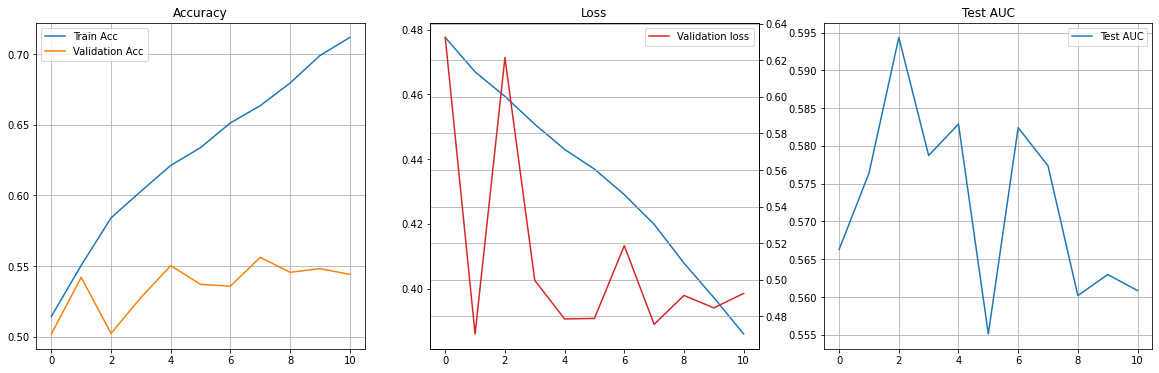

In [ ]:
fig = plt.figure(figsize = (20, 6))
plt.subplot(1, 3, 1)
plt.plot(epoch_tr_acc, label='Train Acc')
plt.plot(epoch_vl_acc, label='Validation Acc')
plt.title("Accuracy")
plt.legend()
plt.grid()

ax1 = plt.subplot(1, 3, 2)
plt.plot(epoch_tr_loss, label='Train loss')
# plt.plot(epoch_vl_loss, label='Validation loss')
plt.title("Loss")
# plt.ylim(0, epoch_tr_loss[1]+0.01)
ax2 = ax1.twinx() 
ax2.plot(epoch_vl_loss, label='Validation loss', color='tab:red')
plt.legend()
plt.grid()

plt.subplot(1, 3, 3)
plt.plot(epoch_auc_roc, label='Test AUC')
plt.title("Test AUC")
# plt.ylim(0, epoch_tr_loss[1]+0.01)
plt.legend()
plt.grid()


plt.show()

In [ ]:
# Evaluate on the validation set for this epoch
real_list = np.asarray([])
pred_list = np.asarray([])
model.eval()
for inputs, labels in valid_loader:

    # Move batch inputs and labels to gpu
    inputs = inputs.float()
    inputs, labels = inputs.to(device), labels.to(device)

    # Compute model output
    output = model(inputs)

    # output = torch.sigmoid(output)
    # pred_list.append(output.squeeze().detach().cpu().numpy())
    # real_list.append(labels.squeeze().detach().cpu().numpy())

    pred_list = np.concatenate([pred_list,output.squeeze().detach().cpu().numpy()],axis=0)
    real_list = np.concatenate([real_list,labels.squeeze().detach().cpu().numpy()],axis=0)


[]

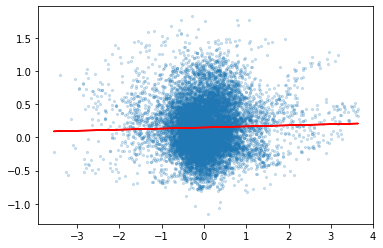

In [ ]:
plt.scatter(real_list,pred_list,s=5,alpha=0.2)
m, b = np.polyfit(real_list, pred_list, 1)
plt.plot(real_list, m*real_list + b,c='red')
# plt.xlim(-10,10)
# plt.ylim(-10,10)
plt.plot()

In [ ]:
y_score = np.asarray(pred_list)
y_test = np.asarray(real_list)

from sklearn.metrics import roc_curve, auc, roc_auc_score

# Compute ROC curve and ROC area for each class

fpr, tpr, _ = roc_curve(y_test>0, y_score)
roc_auc = auc(fpr, tpr)

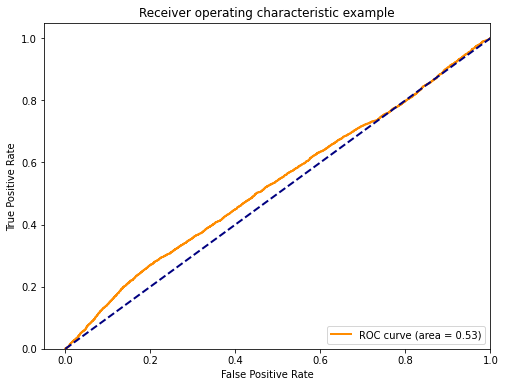

In [ ]:
fig = plt.figure(figsize = (8, 6))
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()